# Prediction of score of stars from gyms in yelp website<br>
Alon Naor 316440221

to start we will call all the imports we will need the the project

In [1]:
#imports
import time
import re
import urllib.request as url
import requests
import json
from datetime import datetime
import random
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler 

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils


from matplotlib.colors import ListedColormap
%matplotlib inline

# this section is about scraping the information we need from Yelp

first we will create the functions that help us extract the relevant information from the site url<br>
the transfom the html file of the string and the cut the information we want from the file

a function the get a gym single shift info as string<br>
convert string time of opening and closing hours to the total time in said shift

In [2]:
def convert_time(time ,cycle):
    time=time.split(":")
    hour=int(time[0])
    minute=int(time[1])
    if cycle == "AM":
        return hour+(minute/60)
    else:
        return hour+12+(minute/60)


a function the get the gym time table as string<br>
return the total time a gym was open each day of the week

In [3]:
def time_caculator_list(time_str):
    time_total_dict={'Sun':0,'Mon':0,'Tue':0,'Wed':0,'Thu':0,'Fri':0,'Sat':0}
    day_index=0
    real_days=['buffer',]
    days_left_split=time_str.split('</p></th>')
    days_right_split=[]
    for i in days_left_split:
        real_days.append(i[-3:])
    schedule_list=[]
    for i in range(1,8):
        try:
            days_right_split= days_left_split[i].split('<p class="no-wrap__09f24__c3plq css-1p9ibgf" data-font-weight="semibold">')
            for i in days_right_split:
                if i[0].isdigit():
                    schedule_list.append(i.split('</p>')[0])
                    schedule=(i.split('</p>')[0])
                    schedule=schedule.split(' ')
                    start=convert_time(schedule[0],schedule[1])
                    end=convert_time(schedule[3],schedule[4])
                    c=(end-start)
                    try:
                        time_total_dict[real_days[day_index]]+=c
                        
                    except:
                        pass
                else:
                    day_index+=1
        except:
            pass
    return time_total_dict          

a function the get the gym html file as string <br>
return the gym name string

In [4]:
def get_gym_name(gym_str):
    name_split=gym_str.split('<h1 class="css-1se8maq">')
    name_chars=name_split[1].split('<')[0]
    return name_chars

a function the get the gym html file as string<br>
return the gym stars number in float type

In [5]:
def get_gym_stars(gym_str):
    star_split=gym_str.split(' star rating')
    star_chars=star_split[0]
    star_num=star_chars.split('"')[-1]
    return float(star_num)

a function the get the gym html file as string<br>
return the gym reviews number in int type

In [6]:
def get_gym_reviews_num(gym_str):
    reviews_split=gym_str.split(' Reviews')
    reviews_chars=reviews_split[0]
    reviews_num=reviews_chars.split(' ')[-1]
    return int(reviews_num)

a function the get the gym html file as string<br>
return the gym expense number in int type

In [7]:
def get_gym_expense(gym_str):
    if gym_str.count('"semibold">$<')>0:
        return 1
    elif gym_str.count('"semibold">$$<')>0:
        return 2
    elif gym_str.count('"semibold">$$$<')>0:
        return 3
    else:
        return 0

a function the get the gym html file as string<br>
return the gym activities names in list of strings type

In [8]:
def get_gym_activities(gym_str):
    lst=[]
    activities_split=gym_str.split('class="css-1m051bw">') 
    for i in activities_split:
        j=i.split('</a>')[0]
        
        if re.search("^[a-zA-Z]", j) is not None:
            #print(j)
            lst.append(j) 
    return lst

a function the get the gym html file as string<br>
return a dictionary with all the properties of the gym

In [9]:
def single_gym_info(html_string):
    gym_dict={
        "name":"",
        "stars":0,
        "review_num":"",
        "expense":0,
        "activities":[],
        "Mon":0,"Tue":0,"Wed":0,"Thu":0,"Fri":0,"Sat":0,"Sun":0}

    #gym name
    gym_dict['name']=get_gym_name(html_string)

    #gym stars num
    gym_dict['stars']=get_gym_stars(html_string)

    #gym reviews num
    gym_dict['review_num']=get_gym_reviews_num(html_string)

    #expense
    gym_dict['expense']=get_gym_expense(html_string)

    #activities
    gym_dict["activities"]=get_gym_activities(html_string)

    #opening time
    opening_dict={"Mon":0,"Tue":0,"Wed":0,"Thu":0,"Fri":0,"Sat":0,"Sun":0}
    opening_split=html_string.split('<table class="hours-table__09f24__KR8wh css-1jtriov">')
    opening_split=opening_split[1].split('</table>')[0]
    opening_dict=time_caculator_list(opening_split)
    for day, time in opening_dict.items():
            gym_dict[day]=time
            
    return gym_dict

a function the get a yelp search for gym page html file as string <br>
return a list with the links of the gyms in this page

In [10]:
def gyms_link_10(html_string):
    space_split=[]
    herf_split=[]
    quotes_split=[]
    gyms_links=[]
    unique_flag=True
    biz_flag=False

    space_split=html_string.split(" ")
    for i in space_split:
        if i.startswith("href"):
            herf_split.append(i)
    for i in herf_split:
        try:
            quotes_split.append(i.split('"')[1])
        except:
            pass
    for i in quotes_split:
        if i.startswith("/biz/"):
            biz_flag=True
            if len(gyms_links) == 0:
                gyms_links.append(i)
            for j in gyms_links:
                if i.startswith(j[0:13]):
                    unique_flag = False
        if unique_flag and biz_flag:        
            gyms_links.append(i)
        unique_flag=True
        biz_flag=False

    return gyms_links


this funtion run on Yelp main site extracting url of every gym <br>
for every gym the program create a dictionary of it properties<br>
the function save all the gyms dictionaries in a list on a json file for later use

In [ ]:
cities_list=['New+York','Chicago','Houston','Los+Angeles','Phoenix','Philadelphia','San+Antonio']
gyms_lists_to_json=[]
index=0
failed_index=0
yelp_https='https://www.yelp.com'

for city in cities_list:
    for stack in range(0,231,10):
        url = yelp_https+'/search?find_desc=Gyms&find_loc=+city+%2C+TX%2C+United+States&start='+str(stack)
        html = requests.get(url)
        x=(gyms_link_10(html.text))
        print("stack length:"+str(len(x))+" stak num:"+str(stack))
        for i in x:
            time.sleep(random.randint(61, 70))
            index+=1
            print(index)
            url = yelp_https+i
            #print(yelp_https+i)
            html = requests.get(url)
            try:
                gyms_lists_to_json.append(single_gym_info(html.text))
                failed_index=0
            except:
                failed_index+=1
                print("failed")
            if failed_index > 5:
                break
        if len(x) == 0:
               break
        failed_index=0
        time.sleep(random.randint(71, 80))
    
    
print()
print('complete')
print('list length:'+str(len(gyms_lists_to_json)))
with open('Gyms_List.json', 'w') as fout:
    json.dump(gyms_lists_to_json, fout)


# Creating the DataFrame

now we need to organize all the dictionaries with diffrent sizes
to a single form so we will be able to create a dataframe from them

we will start by extracting from the json file

In [11]:
gyms_list=[]    
with open('Gyms_List.json') as json_file :
    gyms_list = json.load(json_file)
print(len(gyms_list))

1771


creating unique activities list from all the gyms dictionaries

In [12]:
activity_list=[]
for gym in gyms_list:
    for activity in gym['activities']:
        if activity not in activity_list:
            activity_list.append(activity)
print(activity_list)

['Gyms', 'Trainers', 'Swimming Lessons/Schools', 'Coffee &amp; Tea', 'Acai Bowls', 'Juice Bars &amp; Smoothies', 'Swimming Pools', 'Yoga', 'Cardio Classes', 'Boxing', 'Weight Loss Centers', 'Circuit Training Gyms', 'Physical Therapy', 'Day Spas', 'Sports Clubs', 'Preschools', 'Summer Camps', 'Performing Arts', 'Interval Training Gyms', 'Boot Camps', 'Massage', 'Saunas', 'Golf Lessons', 'Climbing', 'Cultural Center', 'Gymnastics', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates', 'Fitness/Exercise Equipment', 'Barre Classes', 'Tennis', 'ROTD 9/28/2015', 'Cycling Classes', 'Martial Arts', 'Day Camps', 'Cryotherapy', 'Cafes', 'Pickleball', 'ROTD 6/13/2019', 'Tanning', 'Health Coach', 'ROTD 10/4/2016', 'Kids Activities', 'Rock Climbing', 'Recreation Centers', 'Bikes', 'Spray Tanning', 'ROTD 1/6/2019', 'ROTD 4/18/2015', 'Beer, Wine &amp; Spirits', 'Bars', 'American (Traditional)', 'Kickboxing', 'Meditation Centers', 'ROTD 11/19/2022', 'Community Service/Non-Profit', 'Hiking', 'ROTD 2

for each gym dictionary adding a key for each unique activity (1 if he has it 0 if not)

In [13]:
for gym in gyms_list:
    for activity in activity_list:
        if activity in gym['activities']:
            gym[activity] = 1
        else:
            gym[activity] = 0

an example of a single gym dictionary

In [14]:
print(gyms_list[0])

{'name': 'GYM NYC', 'stars': 4.5, 'review_num': 30, 'expense': 0, 'activities': ['Gyms', 'Trainers'], 'Mon': 16.0, 'Tue': 16.0, 'Wed': 16.0, 'Thu': 16.0, 'Fri': 15.0, 'Sat': 8.0, 'Sun': 8.0, 'Gyms': 1, 'Trainers': 1, 'Swimming Lessons/Schools': 0, 'Coffee &amp; Tea': 0, 'Acai Bowls': 0, 'Juice Bars &amp; Smoothies': 0, 'Swimming Pools': 0, 'Yoga': 0, 'Cardio Classes': 0, 'Boxing': 0, 'Weight Loss Centers': 0, 'Circuit Training Gyms': 0, 'Physical Therapy': 0, 'Day Spas': 0, 'Sports Clubs': 0, 'Preschools': 0, 'Summer Camps': 0, 'Performing Arts': 0, 'Interval Training Gyms': 0, 'Boot Camps': 0, 'Massage': 0, 'Saunas': 0, 'Golf Lessons': 0, 'Climbing': 0, 'Cultural Center': 0, 'Gymnastics': 0, 'Nutritionists': 0, 'Child Care &amp; Day Care': 0, 'Pilates': 0, 'Fitness/Exercise Equipment': 0, 'Barre Classes': 0, 'Tennis': 0, 'ROTD 9/28/2015': 0, 'Cycling Classes': 0, 'Martial Arts': 0, 'Day Camps': 0, 'Cryotherapy': 0, 'Cafes': 0, 'Pickleball': 0, 'ROTD 6/13/2019': 0, 'Tanning': 0, 'Healt

# creating the raw dataframe

In [16]:
df = pd.DataFrame.from_dict(gyms_list)
df

,name,stars,review_num,expense,activities,Mon,Tue,Wed,Thu,Fri,...,Community Centers,Dietitians,Sports Medicine,Orthopedists,Basketball Courts,Brazilian Jiu-jitsu,Tanning Beds,Aerial Fitness,Self-defense Classes,ROTD 9/14/2021
0,GYM NYC,4.5,30,0,"[Gyms, Trainers]",16.0,16.0,16.00,16.00,15.0,...,0,0,0,0,0,0,0,0,0,0
1,Mercedes Club,4.0,159,0,"[Gyms, Trainers, Swimming Lessons/Schools]",16.5,16.5,16.50,16.50,15.5,...,0,0,0,0,0,0,0,0,0,0
2,Playa Bowls,3.5,38,0,"[Coffee &amp; Tea, Acai Bowls, Juice Bars &amp...",14.0,14.0,14.00,14.00,13.0,...,0,0,0,0,0,0,0,0,0,0
3,Chelsea Piers Fitness,4.0,198,0,"[Gyms, Swimming Pools, Yoga]",16.5,16.5,16.50,16.50,16.5,...,0,0,0,0,0,0,0,0,0,0
4,TMPL - Avenue A,4.5,26,0,[Gyms],17.5,17.5,17.50,17.50,16.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,Planet Fitness,2.5,15,0,"[Gyms, Trainers]",0.0,0.0,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1767,Tru Fit Athletic Clubs - 410 &amp; Bandera,2.5,62,0,[Gyms],7.0,7.0,7.00,7.00,17.0,...,0,0,0,0,0,0,0,0,0,0
1768,STW Krav Maga,2.5,93,0,"[Gyms, Self-defense Classes]",11.0,11.0,11.00,11.00,10.0,...,0,0,0,0,0,0,0,0,1,0
1769,EnergyX Fitness,5.0,31,0,"[Gyms, Trainers]",6.5,8.0,6.25,7.75,6.5,...,0,0,0,0,0,0,0,0,0,0


now we need to scan the dataframe for corrupted rows and duplicates
before we start working on it
we already saw some unnecessary activities so we will deal with them first

# cleaning the dataframe

we will start remove unnecessary columns

In [17]:
gym_df = df.copy()

gym_df.drop(['activities'], axis=1, inplace=True)
gym_df.drop(['ROTD 9/14/2021'], axis=1, inplace=True)
gym_df.drop(['ROTD 2/24/2019'], axis=1, inplace=True)
gym_df.drop(['ROTD 11/19/2022'], axis=1, inplace=True)
gym_df.drop(['ROTD 4/18/2015'], axis=1, inplace=True)
gym_df.drop(['ROTD 1/6/2019'], axis=1, inplace=True)
gym_df.drop(['ROTD 10/4/2016'], axis=1, inplace=True)
gym_df.drop(['ROTD 6/13/2019'], axis=1, inplace=True)
gym_df.drop(['ROTD 9/28/2015'], axis=1, inplace=True)

remove non Gyms rows 

In [18]:
gym_df = gym_df[gym_df.Gyms != 0]
gym_df.drop(['Gyms'], axis=1, inplace=True)

remove gym with negative opening hours count

In [19]:
gym_df = gym_df[gym_df.Mon >= 0]
gym_df = gym_df[gym_df.Tue >= 0]
gym_df = gym_df[gym_df.Wed >= 0]
gym_df = gym_df[gym_df.Thu >= 0]
gym_df = gym_df[gym_df.Fri >= 0]
gym_df = gym_df[gym_df.Sat >= 0]
gym_df = gym_df[gym_df.Sun >= 0]

remove empty schedule gyms

In [20]:
for index, row in gym_df.iterrows():
    if row['Mon'] <=0 and row['Tue'] <=0 and row['Wed'] <=0 and row['Thu'] <=0 and row['Fri'] <=0 and row['Sat'] <=0 and row['Sun'] <=0:
        gym_df = gym_df[gym_df.name != row['name']]

removing empty column       

In [21]:
for (columnName, columnData) in gym_df.iteritems():
    zero_flag=True
    for i in columnData:
        if i !=0:
            zero_flag=False
    if zero_flag:
        gym_df.drop([columnName], axis=1, inplace=True)
        activity_list.remove(columnName)

remove duplicates

In [22]:

gym_df.drop_duplicates(inplace=True, ignore_index=True)

# Final dataframe

In [23]:
gym_df

,name,stars,review_num,expense,Mon,Tue,Wed,Thu,Fri,Sat,...,Meditation Centers,Community Service/Non-Profit,Hiking,Venues &amp; Event Spaces,Massage Therapy,Community Centers,Dietitians,Brazilian Jiu-jitsu,Aerial Fitness,Self-defense Classes
0,GYM NYC,4.5,30,0,16.0,16.0,16.0,16.0,15.0,8.0,...,0,0,0,0,0,0,0,0,0,0
1,Mercedes Club,4.0,159,0,16.5,16.5,16.5,16.5,15.5,12.0,...,0,0,0,0,0,0,0,0,0,0
2,Chelsea Piers Fitness,4.0,198,0,16.5,16.5,16.5,16.5,16.5,12.0,...,0,0,0,0,0,0,0,0,0,0
3,TMPL - Avenue A,4.5,26,0,17.5,17.5,17.5,17.5,16.5,12.0,...,0,0,0,0,0,0,0,0,0,0
4,Encore Fitness,5.0,12,0,16.0,16.0,16.0,16.0,16.0,10.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,Hays Communities YMCA,3.5,39,0,14.0,14.0,14.0,14.0,12.0,10.0,...,0,0,0,0,0,0,0,0,0,0
608,Gold&#x27;s Gym - San Antonio,2.5,47,0,18.0,18.0,18.0,18.0,18.0,12.0,...,0,0,0,0,0,0,0,0,0,0
609,Gold&#x27;s Gym - San Antonio Live Oak,2.0,62,0,18.0,18.0,18.0,18.0,18.0,12.0,...,0,0,0,0,0,0,0,0,0,0
610,Tru Fit Athletic Clubs - 410 &amp; Bandera,2.5,62,0,7.0,7.0,7.0,7.0,17.0,11.0,...,0,0,0,0,0,0,0,0,0,0


a few side function for the machine learning

removing the unneccesary columns names from

In [24]:
activity_list.remove('ROTD 9/14/2021')
activity_list.remove('ROTD 2/24/2019')
activity_list.remove('ROTD 11/19/2022')
activity_list.remove('ROTD 4/18/2015')
activity_list.remove('ROTD 1/6/2019')
activity_list.remove('ROTD 10/4/2016')
activity_list.remove('ROTD 6/13/2019')
activity_list.remove('ROTD 9/28/2015')
activity_list.remove('Gyms')
print(activity_list)

['Trainers', 'Swimming Lessons/Schools', 'Juice Bars &amp; Smoothies', 'Swimming Pools', 'Yoga', 'Cardio Classes', 'Boxing', 'Weight Loss Centers', 'Physical Therapy', 'Day Spas', 'Sports Clubs', 'Preschools', 'Summer Camps', 'Performing Arts', 'Boot Camps', 'Massage', 'Saunas', 'Golf Lessons', 'Climbing', 'Cultural Center', 'Gymnastics', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates', 'Fitness/Exercise Equipment', 'Barre Classes', 'Tennis', 'Cycling Classes', 'Martial Arts', 'Day Camps', 'Cryotherapy', 'Pickleball', 'Tanning', 'Health Coach', 'Kids Activities', 'Rock Climbing', 'Recreation Centers', 'Bikes', 'Kickboxing', 'Meditation Centers', 'Community Service/Non-Profit', 'Hiking', 'Venues &amp; Event Spaces', 'Massage Therapy', 'Community Centers', 'Dietitians', 'Brazilian Jiu-jitsu', 'Aerial Fitness', 'Self-defense Classes']


Now we dont want to deal with activities that return a small number of times<br>
so we will find those that return above 10 time in the dataframe

In [25]:
activity_dict={}
for act in activity_list:
    activity_dict[act] = 0
for index, row in gym_df.iterrows():
    for act in activity_list:
        activity_dict[act]+=row[act]
for act, num in activity_dict.items():
    if num>10:
        print(act+" : "+str(num))   
        

Trainers : 342
Swimming Pools : 17
Yoga : 100
Cardio Classes : 27
Boxing : 23
Weight Loss Centers : 16
Day Spas : 37
Sports Clubs : 48
Boot Camps : 55
Nutritionists : 12
Child Care &amp; Day Care : 26
Pilates : 29
Cycling Classes : 14
Martial Arts : 12


# EDA and Visualization

for the acivities we collected we will check thier appearances with connection to the gym stars score

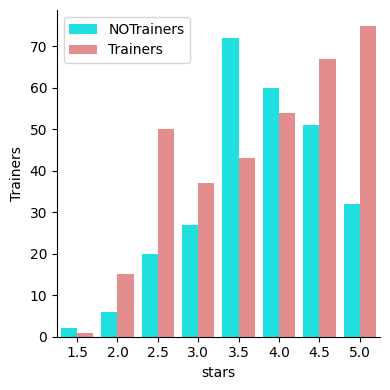

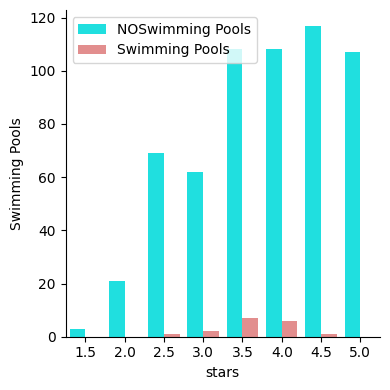

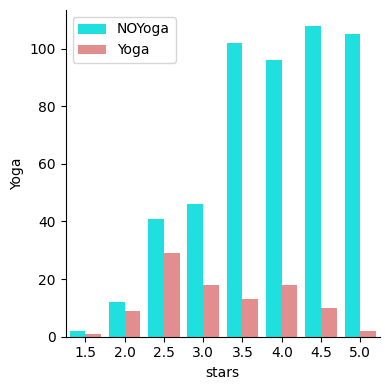

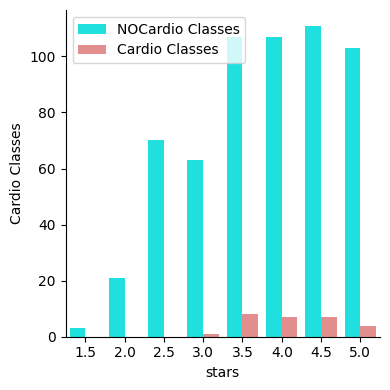

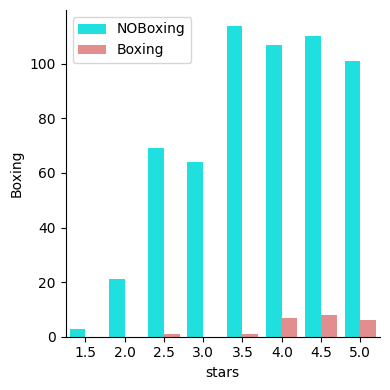

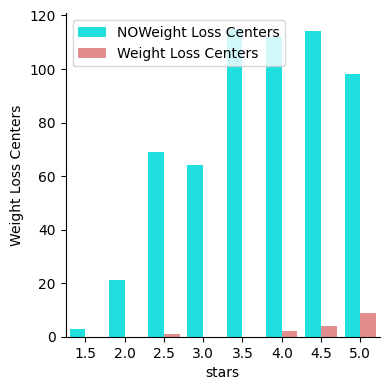

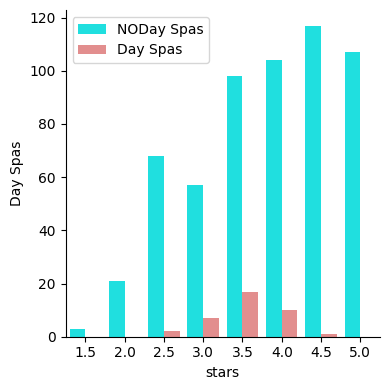

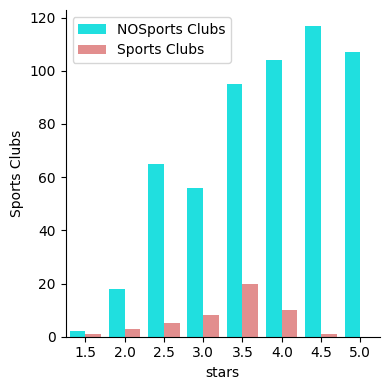

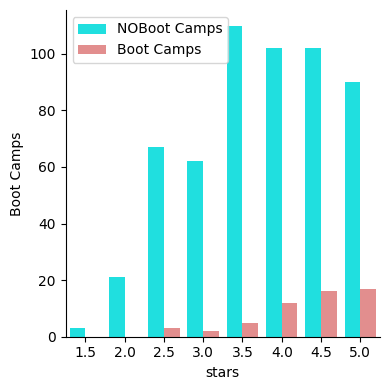

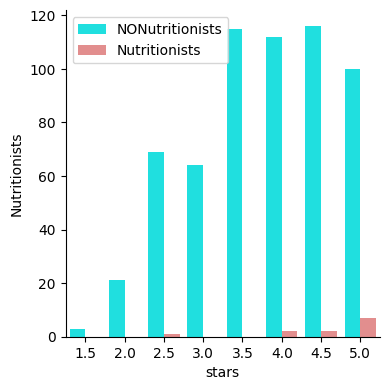

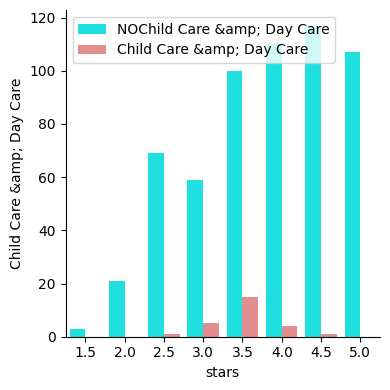

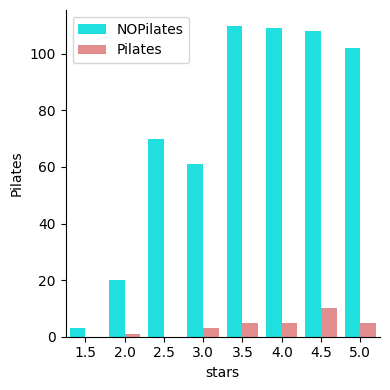

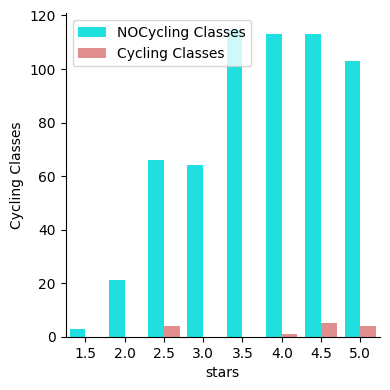

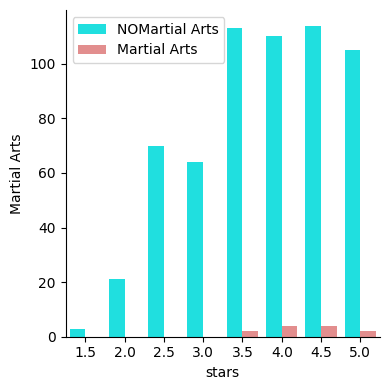

In [26]:
for act, num in activity_dict.items():
    if num>10:
        g = sns.catplot(
            x='stars', 
            data=gym_df,
            kind='count', 
            hue=act,
            palette=["cyan", "lightcoral"], 
            height=4, 
            aspect=1,
            legend=False,
            ).set_axis_labels('stars', act)
        g.ax.legend(labels=['NO'+ act ,act])

here i will use a heat map to check for connection between the number of reviews and the schedule of the gym to it stars score 

<Axes: >

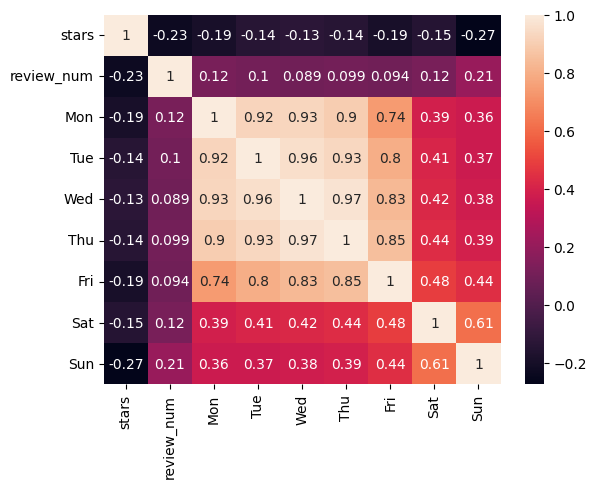

In [27]:
stars_df = pd.DataFrame(gym_df, columns = ['stars','review_num','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
sns.heatmap(stars_df.corr(), annot=True)

I did not find any connection so I will continue to look at a few scatter plots to find more information<br>
scatter plot between stars and reviews

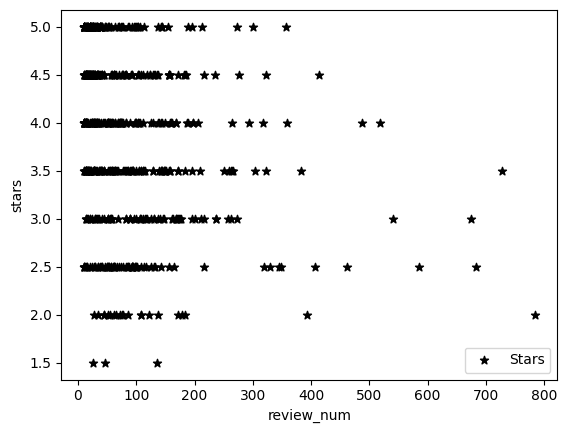

In [28]:
plt.scatter(x=gym_df['review_num'],y=gym_df['stars'],c='k',marker='*',label='Stars')
plt.legend(numpoints=1,loc=4)
plt.xlabel('review_num')
plt.ylabel('stars')
plt.show()

I will also do scatter plots for very day of the week

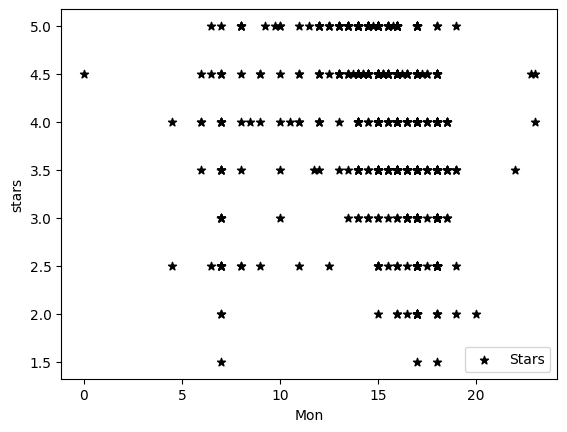

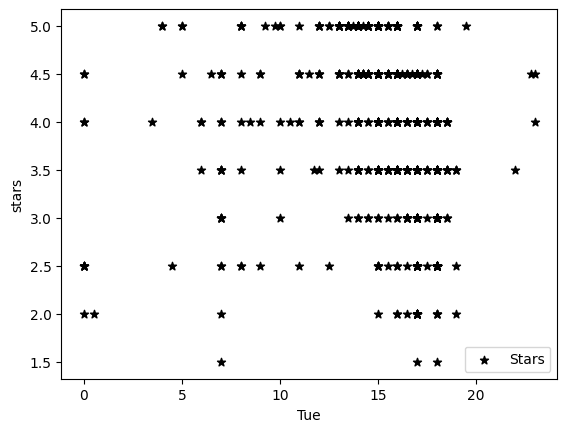

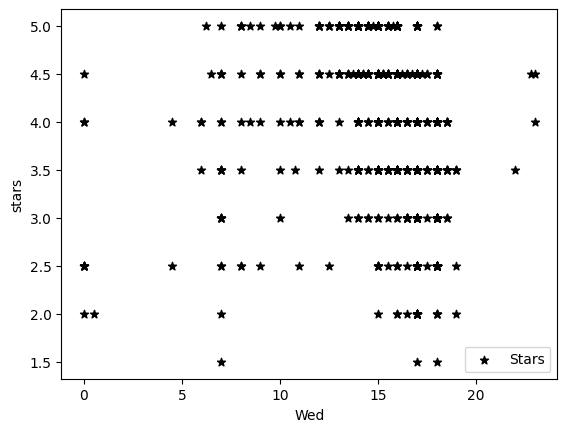

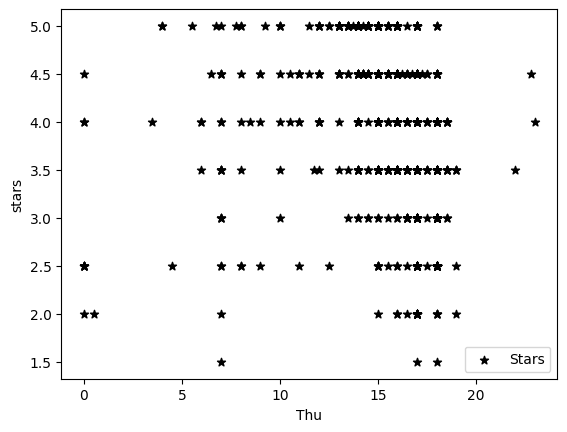

In [29]:
for day in ['Mon','Tue','Wed','Thu']:
    plt.scatter(x=gym_df[day],y=gym_df['stars'],c='k',marker='*',label='Stars')
    plt.legend(numpoints=1,loc=4)
    plt.xlabel(day)
    plt.ylabel('stars')
    plt.show()

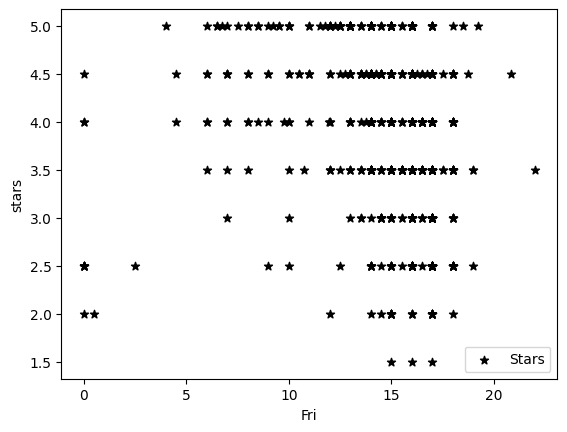

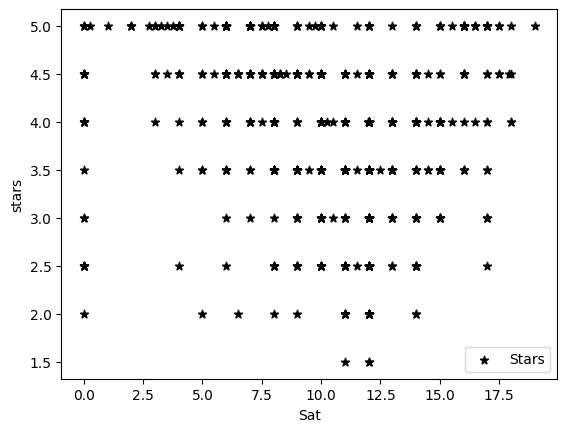

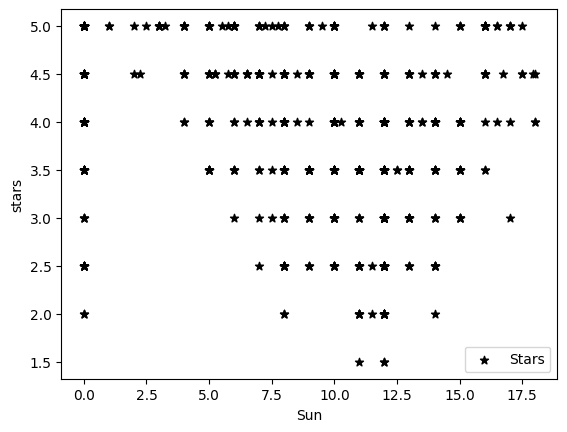

In [30]:
for day in ['Fri','Sat','Sun']:
    plt.scatter(x=gym_df[day],y=gym_df['stars'],c='k',marker='*',label='Stars')
    plt.legend(numpoints=1,loc=4)
    plt.xlabel(day)
    plt.ylabel('stars')
    plt.show()

I will now move to machine learning starting with linear regression

In [31]:
lr = linear_model.LinearRegression() 

x = gym_df[['review_num','expense','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Trainers', 'Swimming Pools',
            'Yoga','Cardio Classes','Boxing', 'Weight Loss Centers','Day Spas','Sports Clubs',
            'Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates','Cycling Classes', 
            'Martial Arts']]
y = gym_df['stars']
lr.fit(X=x, y=y);
print("Slope:",lr.coef_)
print("Intercept:",lr.intercept_)
print("R2:",r2_score(y,lr.predict(x.values)))


Slope: [-0.00095334 -0.12353054 -0.14806951  0.00865898  0.19123641 -0.04602329
 -0.03860744  0.00788723 -0.0329772   0.06833993 -0.00321711 -0.58729399
  0.25338252  0.20880601  0.50321007  0.67637214 -0.72665085  0.35572446
  0.40958943 -0.4665683   0.38151198  0.16698328  0.35374384]
Intercept: 4.619443501510508
R2: 0.30487158956971605


the R2 score was insufficient so we will try to improve it 

Linear Regression model for schedule

In [32]:
x = gym_df[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
y = gym_df['stars']
lr.fit(X=x, y=y);
print("R2:",r2_score(y,lr.predict(x.values)))

R2: 0.1356025972525634


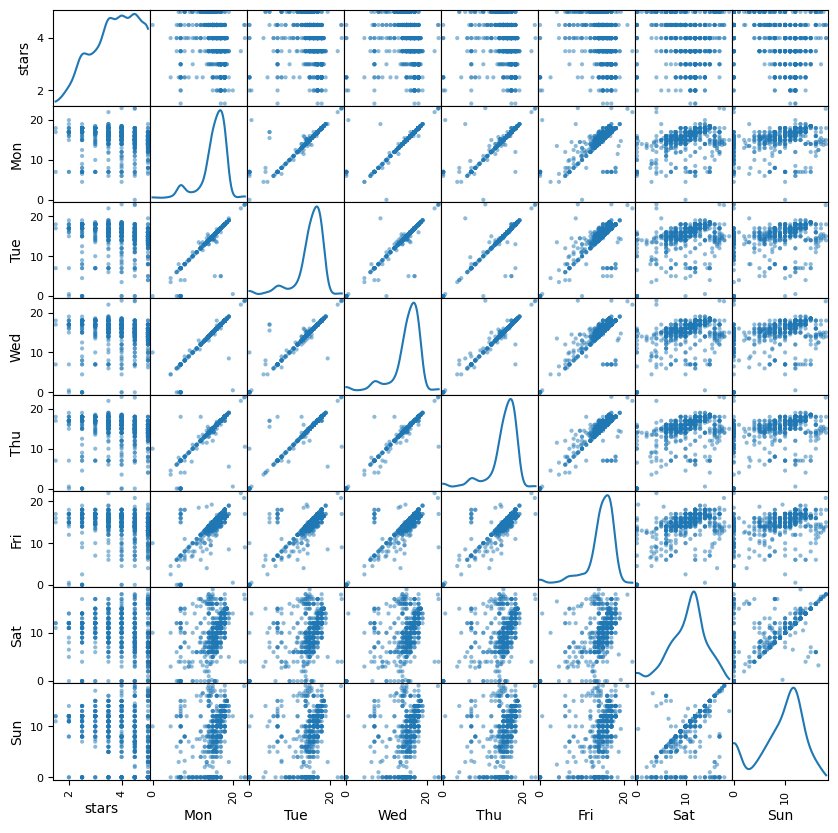

In [33]:
sub_df = pd.DataFrame(gym_df, columns = ['stars','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
pd.plotting.scatter_matrix(sub_df, figsize=(10, 10), diagonal='kde')
plt.show()

Linear Regression model for activities

In [34]:
x = gym_df[['Trainers', 'Swimming Pools',
            'Yoga','Cardio Classes','Boxing', 'Weight Loss Centers','Day Spas','Sports Clubs',
            'Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates','Cycling Classes', 
            'Martial Arts']]
y = gym_df['stars']
lr.fit(X=x, y=y);
print("R2:",r2_score(y,lr.predict(x.values)))

R2: 0.21387778022270953


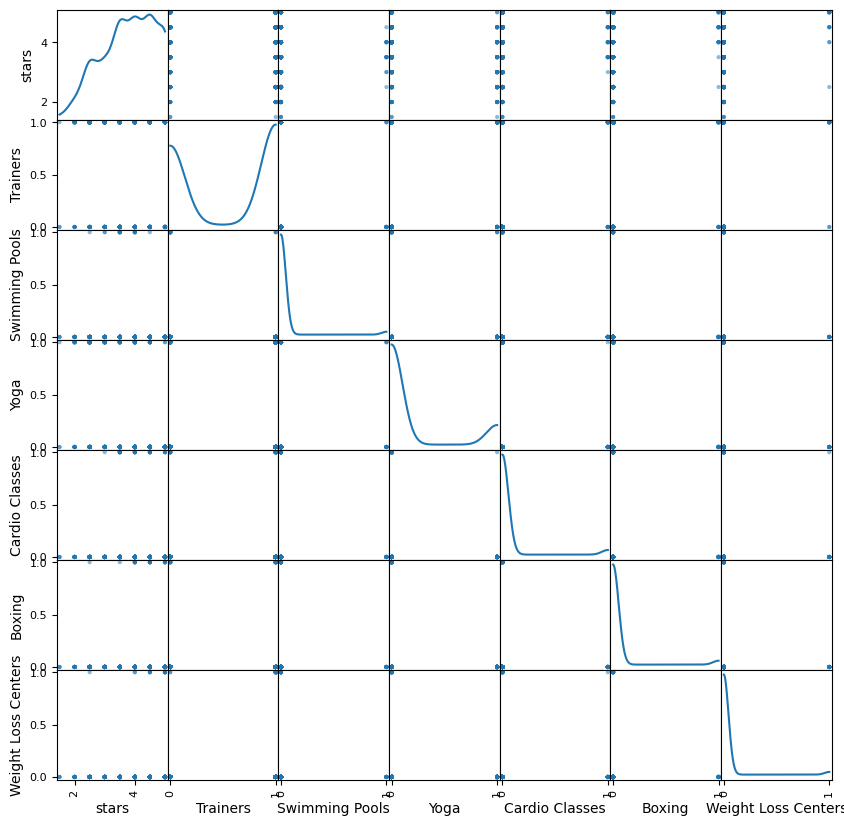

In [35]:
sub_df = pd.DataFrame(gym_df, columns = ['stars','Trainers', 'Swimming Pools',
            'Yoga','Cardio Classes','Boxing', 'Weight Loss Centers'])
pd.plotting.scatter_matrix(sub_df, figsize=(10, 10), diagonal='kde')
plt.show()

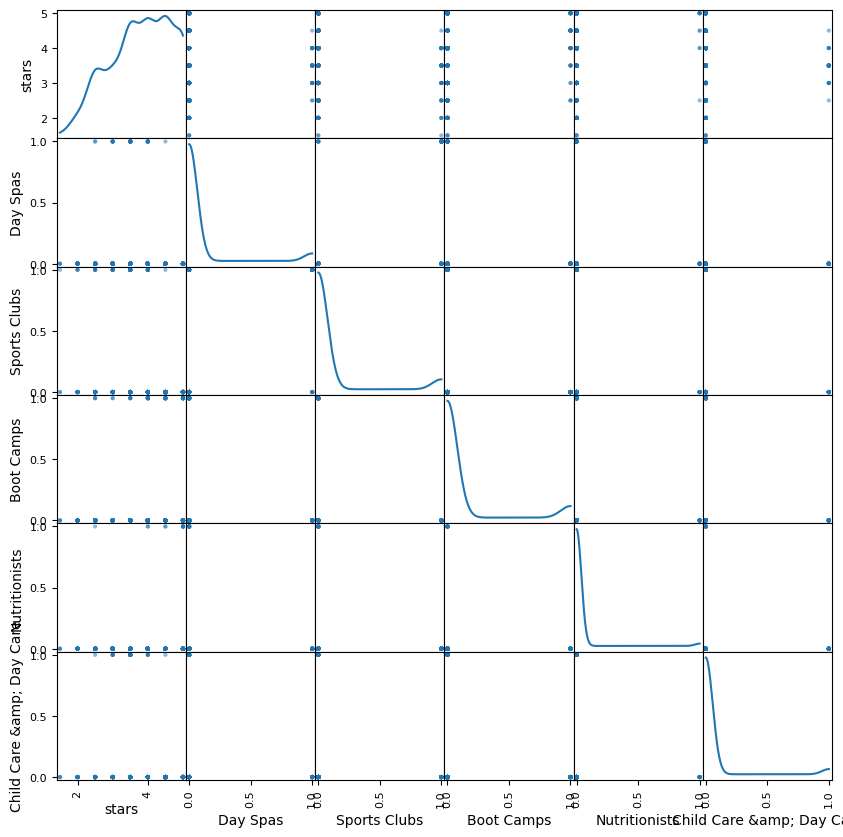

In [36]:
sub_df = pd.DataFrame(gym_df, columns = ['stars','Day Spas','Sports Clubs',
            'Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care'])
pd.plotting.scatter_matrix(sub_df, figsize=(10, 10), diagonal='kde')
plt.show()

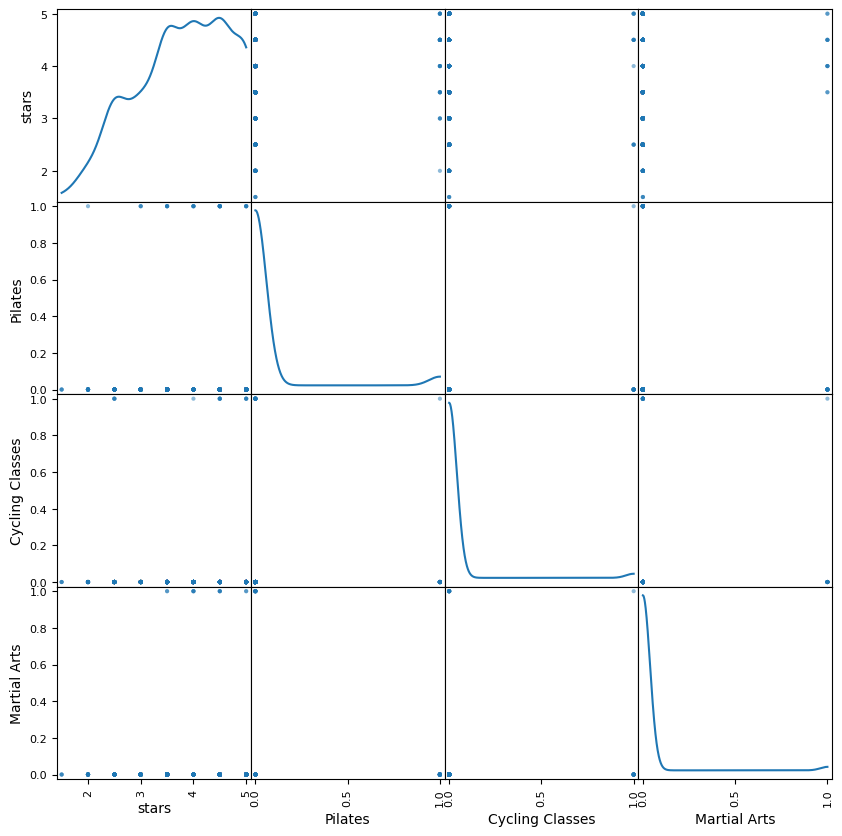

In [37]:
sub_df = pd.DataFrame(gym_df, columns = ['stars','Pilates','Cycling Classes', 
            'Martial Arts'])
pd.plotting.scatter_matrix(sub_df, figsize=(10, 10), diagonal='kde')
plt.show()

loop to find the best R2

In [38]:
list_col=['review_num','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Trainers', 'Swimming Pools',
            'Yoga','Cardio Classes','Boxing', 'Weight Loss Centers','Day Spas','Sports Clubs',
            'Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates','Cycling Classes', 
            'Martial Arts']
best_R2=0
best_col_combo=[]
for col_index in range(len(list_col)):
    for sub_list_index in range(col_index+1,len(list_col)):
        x=gym_df[list_col[col_index:sub_list_index]]
        y=gym_df['stars']
        lr.fit(X=x, y=y);
        if r2_score(y,lr.predict(x.values))> best_R2:
            best_R2 = r2_score(y,lr.predict(x.values))
            best_col_combo=list_col[col_index:sub_list_index]
print('R2:'+str(best_R2))
print('combo: '+str(best_col_combo))


R2:0.2976936638942579
combo: ['review_num', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Trainers', 'Swimming Pools', 'Yoga', 'Cardio Classes', 'Boxing', 'Weight Loss Centers', 'Day Spas', 'Sports Clubs', 'Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates', 'Cycling Classes']


the results were not promising so will try the KNN method

In [39]:
X = gym_df[['review_num','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Trainers', 'Swimming Pools',
            'Yoga','Cardio Classes','Boxing', 'Weight Loss Centers','Day Spas','Sports Clubs',
            'Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates','Cycling Classes', 
            'Martial Arts']]
y = gym_df['stars']

XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.2)
scaler = StandardScaler()
scaler.fit(XTrain)
XTrain = scaler.transform(XTrain)
XTest = scaler.transform(XTest)

In [40]:
k_s=[]
train_accuracies=[]
test_accuracies=[]
for k in range(1,21):
    clf = KNeighborsClassifier(n_neighbors=k)
    
    lab = preprocessing.LabelEncoder()
    yTrain_transformed = lab.fit_transform(yTrain)
    
    lab = preprocessing.LabelEncoder()
    yTest_transformed = lab.fit_transform(yTest)
    
    
    clf.fit(XTrain, yTrain_transformed)
    y_pred_train=clf.predict(XTrain)
    y_pred=clf.predict(XTest)
    k_s.append(k)
    train_accuracies.append(metrics.accuracy_score(y_true = yTrain_transformed, y_pred = y_pred_train))
    test_accuracies.append(metrics.accuracy_score(y_true = yTest_transformed, y_pred = y_pred))

df=pd.DataFrame({"k":k_s,"train_accuracy":train_accuracies,"test_accuracy":test_accuracies})
df

,k,train_accuracy,test_accuracy
0,1,1.000000,0.235772
1,2,0.611452,0.203252
2,3,0.533742,0.186992
3,4,0.546012,0.195122
4,5,0.552147,0.211382
5,6,0.496933,0.219512
6,7,0.472393,0.195122
7,8,0.451943,0.170732
8,9,0.431493,0.178862
9,10,0.449898,0.170732


KNN didn't brought us good results either so we will try decision tree method

In [41]:
X = gym_df[['review_num','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Trainers', 'Swimming Pools',
            'Yoga','Cardio Classes','Boxing', 'Weight Loss Centers','Day Spas','Sports Clubs',
            'Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care', 'Pilates','Cycling Classes', 
            'Martial Arts']]
y = gym_df['stars']

XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.2)

lab = preprocessing.LabelEncoder()
yTrain_transformed = lab.fit_transform(yTrain)
    
lab = preprocessing.LabelEncoder()
yTest_transformed = lab.fit_transform(yTest)


In [42]:
features = ['Trainers', 'Swimming Pools','Yoga','Cardio Classes','Boxing', 'Weight Loss Centers',
            'Day Spas','Sports Clubs','Boot Camps', 'Nutritionists', 'Child Care &amp; Day Care',
            'Pilates','Cycling Classes','Martial Arts']

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain_transformed)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain_transformed, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest_transformed, y_pred = y_pred))


Accuracy on training data=  1.0
Accuracy on test data=  0.24390243902439024


again we did not 